In [1]:
from tqdm import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import random

# Importing data from file

In [2]:
# Read data from ./coauthorship/coauthorship_cond-mat/cond-mat.net
A = np.zeros((16726,16726))
with open("./coauthorship/coauthorship_cond-mat/cond-mat.net", "r") as data_file:
    for line in data_file.readlines():
        i, j = [int(k) for k in line.split()]
        A[i,j] = 1
        A[j,i] = 1
        
D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i,i] = np.sum(A[i])

In [3]:
# Determining which nodes are in the largest component using DFS
def connected_component(A, i): # A: adjacency matrix, i: node to find component
    visited = []
    S = []
    S.append(i)
    while(len(S) > 0):
        v = S.pop()
        print(len(visited))
        if(v not in visited):
            visited.append(v)
            for d in range(A.shape[0]):
                if(A[v][d] == 1):
                    S.append(d)
                
    return visited

# We can use NetworkX instead for speed.
G = nx.convert_matrix.from_numpy_array(A)
C_n = max(nx.connected_components(G))
C = G.subgraph(C_n)

In [169]:
len(C.edges())

44619

In [170]:
len(C.nodes())

13861

# Computing $L_i$ and its distribution

Note that $\displaystyle L_i=\frac{1}{N-1}\sum_{j\ne i}d_{ij}$, where $d_{ij}$ is the distance between nodes $i$ and $j$.
Futhermore, note that $\displaystyle c_i = \begin{cases}\frac{K[G_i]}{k_i(k_i-1)/2} & k_i \ge 2 \\ 0 & k_i = 0,1\end{cases}$, where $K[G_i] = \displaystyle \frac{1}{2}(A^3)_{ii}$ and $k_i=D_{ii}$ is the degree of node $i$.

In [4]:
# Average path length
L_i = dict([(k, np.average(list(nx.shortest_path_length(C,k).values()))) for k in tqdm(C_n)])

# Save L_i values (25m to calculate)
with open("./coauthorship/coauthorship_cond-mat/average-dist.txt", "w+") as dist_file:
    dist_file.write(str(L_i))
    dist_file.close()

100%|██████████| 13861/13861 [49:06<00:00,  4.70it/s]    


In [4]:
# Alternatively, read from existing file for L_i.
with open("./coauthorship/coauthorship_cond-mat/average-dist.txt", "r") as dist_file:
    L_i = ast.literal_eval(dist_file.readline())
    dist_file.close()

In [7]:
# local clustering coefficient
c_i = nx.clustering(G)

In [8]:
# Calculate L = (1/N) ∑ L_i, the characteristic path length
L_avg = np.average(list(L_i.values()))

# Calculate C = (1/N) ∑ c_i, the clustering coefficient of the graph
C_avg = np.average(list(c_i.values()))

# Calculate D_avg = (1/N) ∑ d_i, the degrees of the nodes in the graph
D_dist = [D[i,i] for i in C_n]
D_avg = np.average(D_dist)

L_avg, C_avg, D_avg

(6.62735073477655, 0.6203627534751613, 6.438063631772599)

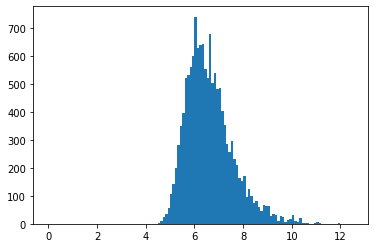

In [9]:
%matplotlib inline
# Plot L_i distribution as histogram.
plt.hist(L_i.values(), bins=np.linspace(0,12.5,126))
plt.show()

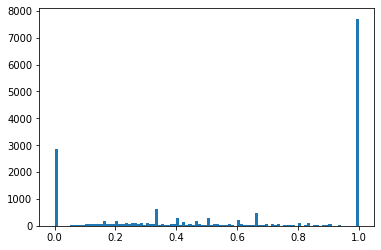

In [10]:
%matplotlib inline
# Plot L_i distribution as histogram.
plt.hist(c_i.values(), bins=np.linspace(0,1,101))
plt.show()

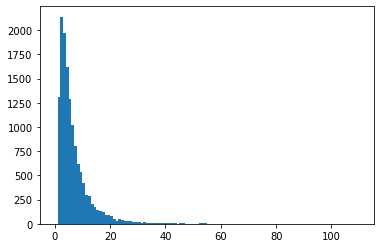

In [11]:
%matplotlib inline
# Plot L_i distribution as histogram.
plt.hist(D_dist, bins=np.linspace(0,110,111))
plt.show()

# Exponential vs. power law distributions

We first analyze a plot of degree and local clustering coefficient, revealing that the graph of $c_i$ (average local clustering coefficient for degree $k_i$) over $k_i$ (degree) has a power law distribution with exponent approximately equal to $-1$.

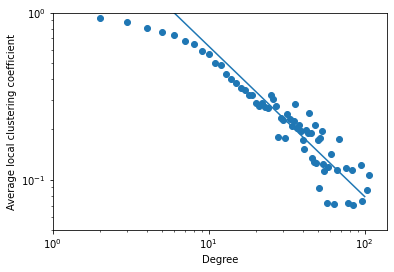

In [159]:
degree_coef = [(D[index, index], coef) for (index, coef) in c_i.items()]

coef_by_degree = {degree: [] for degree, _ in degree_coef}

for degree, coef in degree_coef:
    coef_by_degree[degree].append(coef)

for degree in coef_by_degree.keys():
    coef_by_degree[degree] = np.average(coef_by_degree[degree])

degree_coef_x, degree_coef_y = zip(*list(coef_by_degree.items()))

c_power_law_x = np.linspace(1,100,101)
c_power_law_y = 5*c_power_law_x**(-0.9)

plt.axis((1,140,0.05,1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Average local clustering coefficient")
plt.scatter(degree_coef_x, degree_coef_y)
plt.plot(c_power_law_x, c_power_law_y)
plt.show()

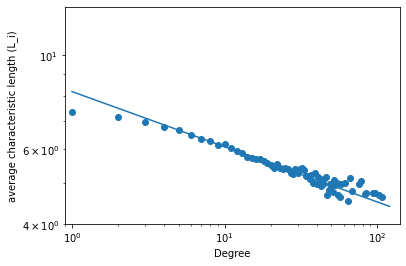

In [160]:
degree_dist = [(D[index, index], dist) for (index, dist) in L_i.items()]

dist_by_degree = {degree: [] for degree, _ in degree_dist}

for degree, dist in degree_dist:
    dist_by_degree[degree].append(dist)

for degree in dist_by_degree.keys():
    dist_by_degree[degree] = np.average(dist_by_degree[degree])

degree_dist_x, degree_dist_y = zip(*list(dist_by_degree.items()))

L_power_law_x = np.linspace(1,120,121)
L_power_law_y = 8.2*L_power_law_x**(-0.13)

plt.axis((0.9,140,4,13))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("average characteristic length (L_i)")
plt.scatter(degree_dist_x, degree_dist_y)
plt.plot(L_power_law_x, L_power_law_y)
plt.show()

# Examining $L$ and $C$ for sampled subgraphs

We first examine the distribution of $C$ for sampled subgraphs of the largest component of the `cond-mat` dataset. We propose multiple different methods for sampling subgraphs.
- Start at a random node, and take a random walk 
- Sample a set of nodes, then find the shortest paths to connect each disconnected component and add those to the subgraph.

distance determining whether there is a node.

Sampling depending on centrality (higher centrality gets picked more often?)

Use graph characteristics to determine sampling.

In [104]:
# Sampling process

C_n_sample = random.sample(C_n, 100)
C_sample = G.subgraph(C_n_sample)

In [105]:
L_i_sample = dict([(k, np.average(list(nx.shortest_path_length(C_sample,k).values()))) for k in tqdm(C_n_sample)])



100%|██████████| 100/100 [00:00<00:00, 10988.20it/s]


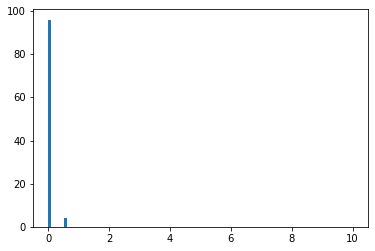

In [106]:
%matplotlib inline
# Plot L_i distribution as histogram.
plt.hist(L_i_sample.values(), bins=np.linspace(0,10,101))
plt.show()

In [25]:
print(np.average(list(L_i_sample.values())))

0.26426388888888885


# Distribution of samples of $L_i$ for subset of nodes

In [138]:
sample_L_n = random.sample(C_n, 200)

sample_L = [np.average([nx.shortest_path_length(C,s,t) for t in sample_L_n]) for s in tqdm(sample_L_n)]





  0%|          | 0/200 [00:00<?, ?it/s]



  0%|          | 1/200 [00:00<00:21,  9.36it/s]



  1%|          | 2/200 [00:00<00:25,  7.77it/s]



  2%|▏         | 3/200 [00:00<00:24,  8.07it/s]



  2%|▏         | 4/200 [00:00<00:22,  8.54it/s]



  2%|▎         | 5/200 [00:00<00:22,  8.61it/s]



  3%|▎         | 6/200 [00:00<00:22,  8.48it/s]



  4%|▎         | 7/200 [00:00<00:22,  8.51it/s]



  4%|▍         | 9/200 [00:01<00:22,  8.67it/s]



  5%|▌         | 10/200 [00:01<00:21,  8.74it/s]



  6%|▌         | 11/200 [00:01<00:26,  7.21it/s]



  6%|▌         | 12/200 [00:01<00:26,  7.05it/s]



  6%|▋         | 13/200 [00:01<00:29,  6.33it/s]



  7%|▋         | 14/200 [00:01<00:32,  5.66it/s]



  8%|▊         | 15/200 [00:02<00:31,  5.83it/s]



  8%|▊         | 16/200 [00:02<00:28,  6.53it/s]



  8%|▊         | 17/200 [00:02<00:27,  6.56it/s]



  9%|▉         | 18/200 [00:02<00:31,  5.81it/s]



 10%|▉         | 19/200 [00:02<00:29,  6.18it/s]



 10%|█         | 20/200 [

 71%|███████   | 142/200 [00:18<00:06,  8.60it/s]



 72%|███████▏  | 143/200 [00:18<00:07,  8.04it/s]



 72%|███████▏  | 144/200 [00:18<00:06,  8.17it/s]



 72%|███████▎  | 145/200 [00:18<00:06,  8.22it/s]



 73%|███████▎  | 146/200 [00:19<00:07,  7.70it/s]



 74%|███████▎  | 147/200 [00:19<00:06,  7.63it/s]



 74%|███████▍  | 148/200 [00:19<00:06,  7.58it/s]



 74%|███████▍  | 149/200 [00:19<00:06,  7.66it/s]



 75%|███████▌  | 150/200 [00:19<00:06,  7.50it/s]



 76%|███████▌  | 151/200 [00:19<00:06,  7.63it/s]



 76%|███████▌  | 152/200 [00:19<00:07,  6.40it/s]



 76%|███████▋  | 153/200 [00:20<00:06,  6.72it/s]



 78%|███████▊  | 155/200 [00:20<00:05,  7.77it/s]



 78%|███████▊  | 156/200 [00:20<00:05,  7.54it/s]



 78%|███████▊  | 157/200 [00:20<00:05,  7.95it/s]



 79%|███████▉  | 158/200 [00:20<00:05,  7.98it/s]



 80%|███████▉  | 159/200 [00:20<00:05,  7.60it/s]



 80%|████████  | 160/200 [00:20<00:05,  7.29it/s]



 80%|████████  | 161/200 [00:21<00:06,  6.43it

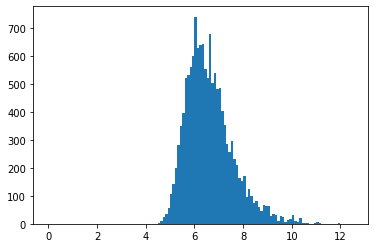

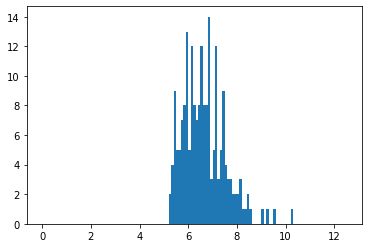

In [141]:
%matplotlib inline
# Plot L_i distribution as histogram.

plt.hist(L_i.values(), bins=np.linspace(0,12.5,126))
plt.show()

plt.hist(sample_L, bins=np.linspace(0,12.5,126))
plt.show()

In [165]:
# L^2-norm on the sampled distribution vs. the actual distribution.
L_graph = np.histogram([k for k in list(L_i.values())], bins=np.linspace(0,12.5,51),density=True)
L_prob = L_graph[0]

L_sample_graph = np.histogram(sample_L, bins=np.linspace(0,12.5,51),density=True)
L_sample_prob = L_sample_graph[0]

np.sum((L_sample_prob-L_prob)**2)**(1/2)

0.23393192584213415

# Using simulated annealing to find coauthorship approximations

Lp spaces as an objective function!
Using the WS model to approximate the provided graph?

Because the small world model describes the characteristic path length growing as $\log(N)$, I used WolframAlpha to solve for $k$ in the equation $\log_k(N)=C_{avg}$ for the given dataset and determined $\log_k(50)/C_{avg}$ as a scaling factor for the histogram.

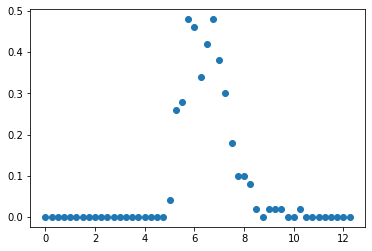

In [142]:
# characteristic path length probability distribution (2.67817/L_avg)*
L_graph = np.histogram([k for k in list(L_i.values())], bins=np.linspace(0,12.5,51),density=True)
L_prob = L_graph[0]

L_sample_graph = np.histogram(sample_L, bins=np.linspace(0,12.5,51),density=True)
L_sample_prob = L_sample_graph[0]

plt.scatter(L_sample_graph[1][:len(L_sample_graph[0])], L_sample_graph[0])
plt.show()

In [153]:
def select_move(G):
    RE = list(filter(None.__ne__, [("remove", e) if nx.edge_connectivity(G, s=e[0], t=e[1])>1 else None for e in G.edges()]))
    RE = random.sample(RE, len(RE))[:min(10,len(RE))]
    #RE = []
    AE = random.sample([("add", e) for e in nx.non_edges(G)], len(G)*(len(G)-1)//2 - len(G.edges()))[:10]
    #AE = []
    #SE = random.sample([("swap", a, b) for a, b in zip(G.edges(), nx.non_edges(G))], LENGTH)[:10]
    SE = []
    return random.choice(RE + AE + SE)

def energy_function(G):
    GL_i = np.array([np.average(list(nx.shortest_path_length(G,k).values())) for k in G.nodes()])
    GL_prob = np.histogram(GL_i, bins=np.linspace(0,12.5,51),density=True)[0]
    return np.sum((GL_prob-L_sample_prob)**2)**(1/2)

def final_energy_function(G): # With the full distribution
    GL_i = np.array([np.average(list(nx.shortest_path_length(G,k).values())) for k in G.nodes()])
    GL_prob = np.histogram(GL_i, bins=np.linspace(0,12.5,51),density=True)[0]
    return np.sum((GL_prob-L_prob)**2)**(1/2)
    
#We use discrete L_p spaces.
def acceptance_probability(G,G_new,T):
    return max(1.0, np.exp(-(energy_function(G_new)-energy_function(G))/(T+1e-12)))

1
50


/Users/bracho/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


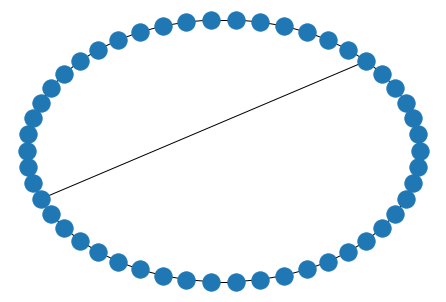

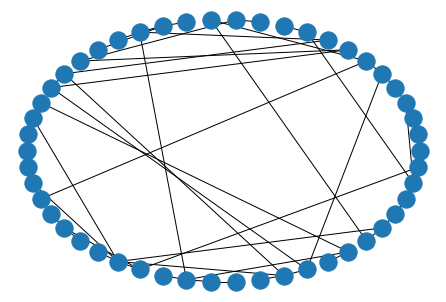

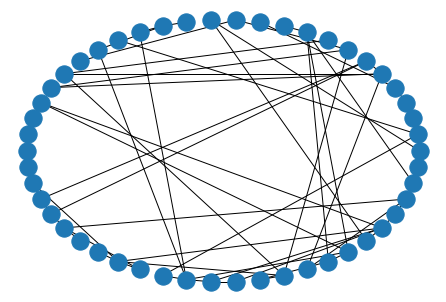

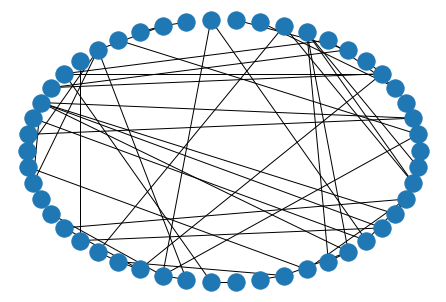

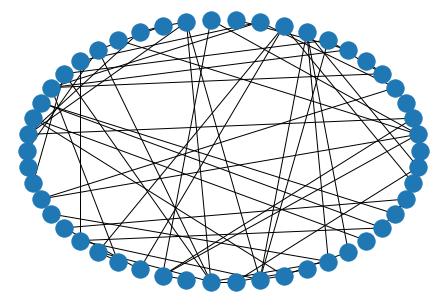

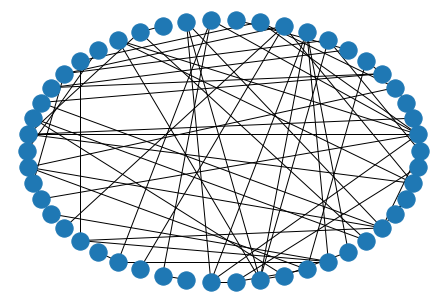

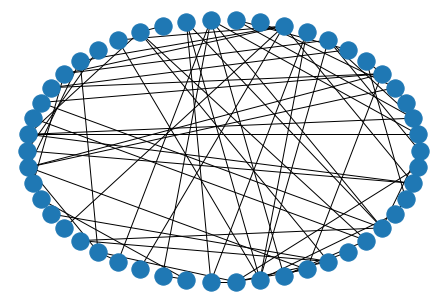

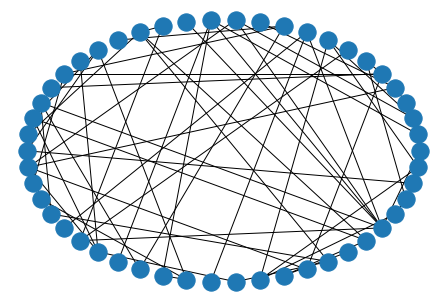

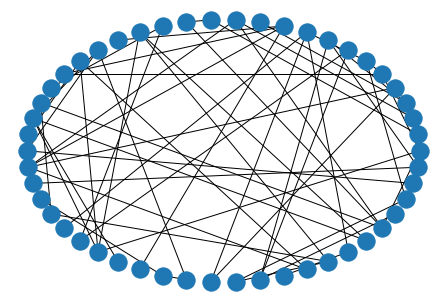

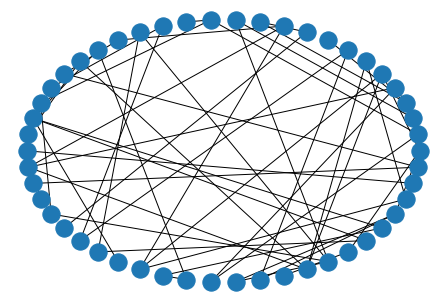

In [144]:
# Start with a WS or circle graph.
STEPS = 500
TEMPERATURE = 5e-7
energy_time = []

SA = nx.generators.random_graphs.watts_strogatz_graph(50,2,0.00) # seed 4552?
print(len(list(nx.connected_components(SA)))) # Should be connected initially.
print(len(SA.edges()))

best_graph = SA
min_energy = float("inf")
      
for step in range(STEPS):
    move = select_move(SA)
    SA_new = SA.copy()
    if(move[0] == "add"):
        SA_new.add_edge(move[1][0], move[1][1])
    if(move[0] == "remove"):
        SA_new.remove_edge(move[1][0], move[1][1])
    if(move[0] == "swap"):
        SA_new.remove_edge(move[1][0], move[1][1])
        SA_new.add_edge(move[2][0], move[2][1])
    
    if(random.random() < acceptance_probability(SA, SA_new, TEMPERATURE)):
        SA = SA_new
        
    TEMPERATURE -= TEMPERATURE/STEPS
    
    if(energy_function(SA) < min_energy):
        min_energy = energy_function(SA)
        best_graph = SA.copy()

    energy_time.append(energy_function(SA))
    if(step % 50 == 0):
        nx.draw_circular(SA)
        plt.show()

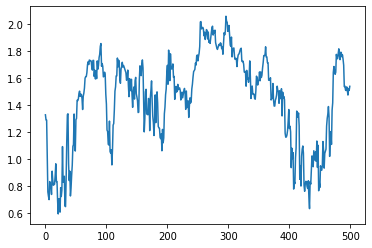

In [145]:
%matplotlib inline

plt.plot(energy_time)
plt.show()

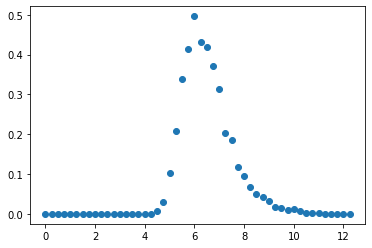

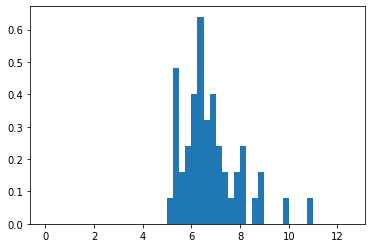

In [146]:
best_graph_max_conn = best_graph.subgraph(max(nx.connected_components(best_graph)))
best_graph_i = np.array([np.average(list(nx.shortest_path_length(best_graph_max_conn,k).values())) for k in best_graph_max_conn.nodes()])

plt.scatter(L_graph[1][:len(L_graph[0])], L_graph[0])
plt.show()
# Plot SA L_i distribution as histogram.

plt.hist(best_graph_i, bins=np.linspace(0,12.5,51), density=True)
plt.show()

In [147]:
len(best_graph_max_conn.edges())

56

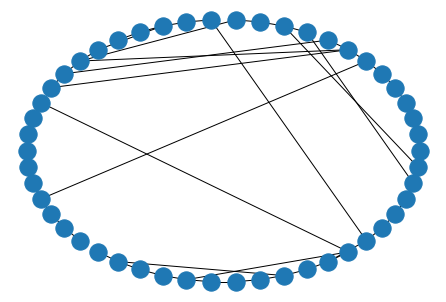

In [148]:
nx.draw_circular(best_graph_max_conn)

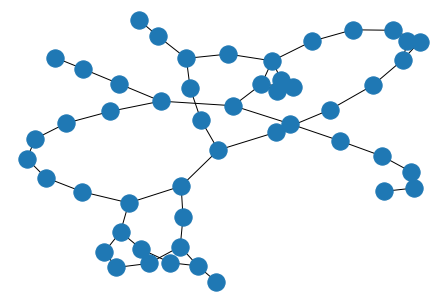

In [149]:
nx.draw(best_graph_max_conn)

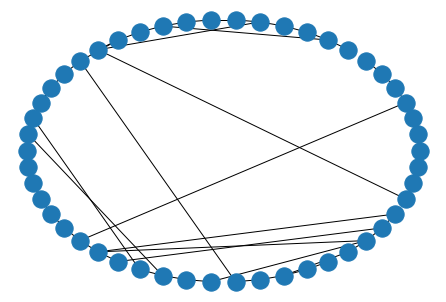

In [181]:
nx.draw_shell(best_graph_max_conn)

In [168]:
best_graph_clustering_i = nx.clustering(best_graph_max_conn)
best_graph_C_avg = np.average(list(best_graph_clustering_i.values()))
best_graph_C_avg

0.0

In [151]:
min_energy

0.5953150426454886

In [154]:
final_energy_function(best_graph)

0.5231029182317908

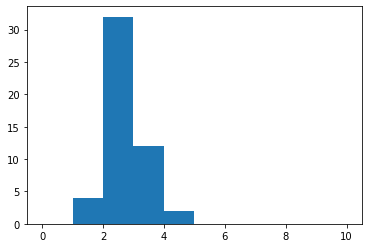

In [155]:
# Calculate D_avg = (1/N) ∑ d_i, the degrees of the nodes in the graph
best_graph_D_dist = [d for n, d in best_graph.degree()]

# Plot degree distribution as histogram.
plt.hist(best_graph_D_dist, bins=np.linspace(0,10,11))
plt.show()

In [166]:
# L for the approximated graph
np.average(best_graph_i)

6.775199999999999

In [167]:
sc = nx.clustering(SA)
av = np.average(list(sc.values()))
av

0.006666666666666667

In [172]:
# The diameter of the approximated graph
nx.diameter(best_graph)

18